In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PATH_SOURCE_DATA'] = '/workspace/projects/boostdm/nature-release/source-data'

In [3]:
import sys
sys.path.append('./scripts/')
import json
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import conf
import oncotree
from discovery import get_mutations, discovery_index_with_bootstrap, master_func, plot_fit, plot_fit_multiple

conf.config_params()
tree = oncotree.Oncotree()

In [5]:
with open(os.path.join(conf.output_boostdm, 'discovery', 'samples_anonymized.json'), 'rt') as g:
    samples = json.load(g)
    
mutations = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'mutations_anonymized.tsv'), sep='\t')

# Extended Figure 1a

In [6]:
# TP53 cancer types
tp53_selected_ttypes = ['AML', 'CM',  'HC', 'GBM', 'BLCA', 'UCEC', 'COREAD', 
                        'ESCA', 'OV', 'BRCA']
cmap = plt.cm.tab20
colors = [cmap(i) for i in range(len(tp53_selected_ttypes))]

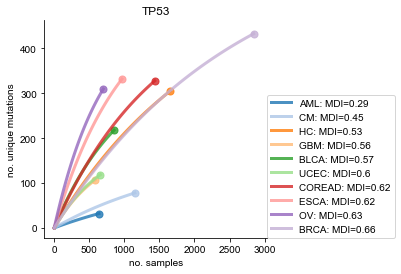

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
for i, ttype in enumerate(tp53_selected_ttypes):
    plot_fit_multiple('TP53', ttype, samples, mutations, ax, color_curve=colors[i])
ax.set_title('TP53')
ax.set_ylabel('no. unique mutations')
plt.legend(loc=(1,0))
plt.savefig('./raw_plots/TP53.discovery.svg', dpi=300, bbox_inches='tight')
plt.show()

# Extended Figure 1c,d

In [8]:
# Individual panels

def plot_discovery_gene_ttype(gene, ttype):
    fig, ax = plt.subplots(figsize=(3, 3))
    plot_fit(gene, ttype, samples, mutations, ax)
    plt.savefig(os.path.join('./raw_plots', f'{gene}.{ttype}.fitplot.svg'))
    plt.show()

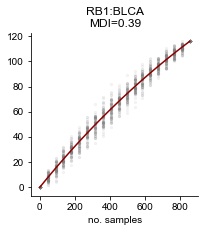

In [9]:
plot_discovery_gene_ttype('RB1', 'BLCA')

In [10]:
# Boxplot bootstrap

def mdi_boxplot_multiple(genes, ttypes, ax, iterations=100, ngrid=20, title=None):

    discs, xs = [], []
    for i, (gene, ttype) in enumerate(zip(genes, ttypes)):
        samp = samples[ttype]
        muts = get_mutations(mutations, ttype, gene)

        params, disc, grid, unique_counts = discovery_index_with_bootstrap(samp, muts, iterations, ngrid)
        discs.append(disc)
        unique_np = np.array(unique_counts)
        xs.append((i+1) + np.random.normal(loc=0, scale=0.02, size=len(disc)))

    # boxplot of median MDI
    ax.boxplot(discs, showfliers=False)
    ys = reduce(lambda x,y: x+y, discs, [])
    ax.set_ylim(0,1)
    ax.scatter(xs, ys, alpha=0.1)
    ax.set_ylabel('discovery index')
    if title is not None:
        ax.set_title(gene + ':' + ttype)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(list(map(lambda x: x[0]+':'+x[1], list(zip(genes, ttypes)))), rotation=90)

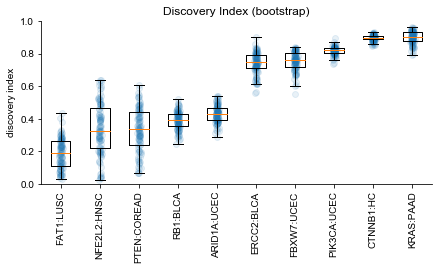

In [11]:
fig, ax = plt.subplots(figsize=(7,3))
mdi_boxplot_multiple(['FAT1', 'NFE2L2', 'PTEN', 'RB1', 'ARID1A', 'ERCC2', 'FBXW7', 'PIK3CA', 'CTNNB1', 'KRAS' ],  
                     ['LUSC', 'HNSC', 'COREAD', 'BLCA', 'UCEC', 'BLCA', 'UCEC', 'UCEC', 'HC', 'PAAD'], 
                     ax)
plt.title('Discovery Index (bootstrap)')
plt.savefig('./raw_plots/bootstrap.svg', dpi=300, bbox_inches='tight')
plt.show()

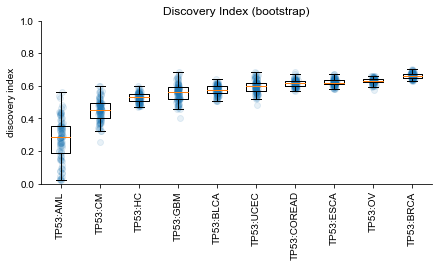

In [12]:
fig, ax = plt.subplots(figsize=(7,3))
mdi_boxplot_multiple(['TP53'] * len(tp53_selected_ttypes), tp53_selected_ttypes, ax)
plt.title('Discovery Index (bootstrap)')
plt.savefig('./raw_plots/bootstrap-tp53.svg', dpi=300, bbox_inches='tight')
plt.show()